# Exploratory Data Analysis

## Dataset description

The [Ryerson Audio-Visual Database of Emotional Speech and Song](https://zenodo.org/record/1188976#.XN0fwnUzZhE) (RAVDESS) contains 7356 files of 24 professional actors (12 females, 12 males), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes 'calm', 'happy', 'sad', 'angry', 'fearful', 'surprise', and 'disgust' expressions, and song contains 'calm', 'happy, 'sad', 'angry', and 'fearful' emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. <br>
All conditions are available in three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound). <br>
<ins>In this analysis, we use Audio-only files</ins>. <br>

Each of the RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., '02-01-06-01-02-01-12.mp4'). <br>
These identifiers define the stimulus characteristics: 
    
**Modality**: (01 = full-AV, 02 = video-only, 03 = audio-only). <br>
**Vocal channel**: (01 = speech, 02 = song). <br>
**Emotion**: (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). <br>
**Emotional intensity**: (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion. <br>
**Statement**: (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). <br>
**Repetition**: (01 = 1st repetition, 02 = 2nd repetition). <br>
**Actor**: (01 to 24. Odd numbered actors are male, even numbered actors are female). <br>

## Importing required libraries

In [2]:
import sys
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

## Loading data

To load the data into a pandas DataFrame, we are going to use the helper function 'read_data' contained in '/aux/reader.py'

In [3]:
sys.path.append('../')
from aux.reader import read_data

DATA_PATH = '../data/'

data_df = read_data(DATA_PATH)
data_df.head()

Using TensorFlow backend.


,path,source,actor,gender,intensity,statement,repetition,emotion
0,Actor_01/03-01-08-02-02-01-01.wav,speech,1,male,1,1,0,surprised
1,Actor_01/03-01-08-01-01-01-01.wav,speech,1,male,0,0,0,surprised
2,Actor_01/03-01-05-01-02-01-01.wav,speech,1,male,0,1,0,angry
3,Actor_01/03-02-03-02-02-02-01.wav,song,1,male,1,1,1,happy
4,Actor_01/03-01-06-01-02-02-01.wav,speech,1,male,0,1,1,fearful


##  Class statistics

### Emotions counts 

I am going to print out the audio sample counts for each emotion, separating between *song* and *speech* types. Since I will train different models for female and male speakers, we show separate statistics.

In [4]:
def stats(df):

    grouped = df.groupby(['emotion', 'source']).size().unstack()

    grouped['summed count'] = grouped.sum(axis=1)
    grouped.loc['total'] = grouped.sum()

    display(data_df_r.groupby('emotion').count()['path'].plot(kind='barh'))
    
    display(grouped.fillna(0).astype(int))

In [6]:
# emotion and souce maps
emotion_map = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
               5: 'angry', 6: 'fearful', 7 : 'disgust', 8 : 'surprised'}

source_map = {1 : 'speech', 2 : 'song'}

data_df_r = data_df.replace({"emotion": emotion_map, "source": source_map})

data_df_r_male = data_df_r[data_df_r.gender=='male']
data_df_r_female = data_df_r[data_df_r.gender=='female']

source,song,speech,summed count
emotion,,,
angry,64,96,160
calm,64,96,160
disgust,0,96,96
fearful,64,96,160
happy,64,96,160
neutral,32,48,80
sad,64,96,160
surprised,0,96,96
total,352,720,1072


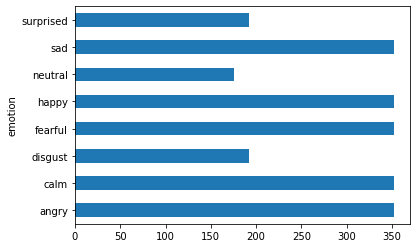

In [7]:
stats(data_df_r_female)

In total the dataset contains 1072 files for *female* speakers: 352 *song* files and 720 *speech* files. <br>

source,song,speech,summed count
emotion,,,
angry,96,96,192
calm,96,96,192
disgust,0,96,96
fearful,96,96,192
happy,96,96,192
neutral,48,48,96
sad,96,96,192
surprised,0,96,96
total,528,720,1248


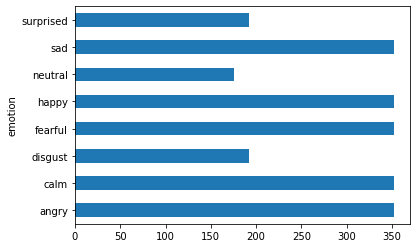

In [8]:
stats(data_df_r_male)

In total the dataset contains 1248 files: 528 *song* files and 720 *speech* files. <br>

### Check completeness 

We are going to check if each emotions is included in noth *song* and *speech* versions of the data.

In [9]:
data_df_r_female.groupby('emotion')['source'].unique()

emotion
angry        [speech, song]
calm         [song, speech]
disgust            [speech]
fearful      [speech, song]
happy        [song, speech]
neutral      [song, speech]
sad          [speech, song]
surprised          [speech]
Name: source, dtype: object

In [10]:
data_df_r_male.groupby('emotion')['source'].unique()

emotion
angry        [speech, song]
calm         [song, speech]
disgust            [speech]
fearful      [speech, song]
happy        [song, speech]
neutral      [song, speech]
sad          [speech, song]
surprised          [speech]
Name: source, dtype: object

Note that emotions 'surprised, 'neutral' and 'disgust' are not included in the song version data for female and male speakers. For this reason, I won't include them in the analysis. <br>

I am now going to check if all actors perform *song* and *speech* for each vocal statement.

In [11]:
def check_source(df):
    actors_out = []
    for actor in df.actor.unique():
        if set(df[df.actor==actor]['source'].unique()) != set(['song', 'speech']):
            actors_out.append(actor)
    return actors_out 

In [12]:
check_source(data_df_r_female)  

[6, 12, 18, 24]

In [13]:
check_source(data_df_r_male)  

[]

Female actresses 6, 12, 18, 24 do not have both *song* and *speech* versions of data.

### Emotion statements for each actors

Let's breakdown emotion statement counts for each actor.

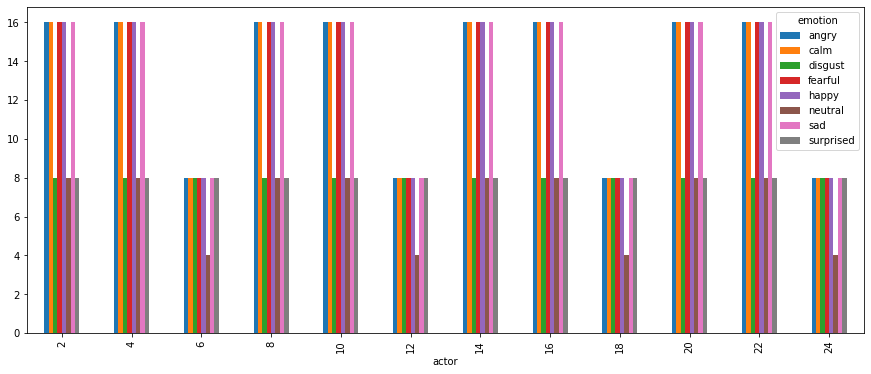

In [14]:
data_df_r_female.groupby(['actor', 'emotion'])['repetition'].count().unstack().plot.bar(figsize=(15,6))

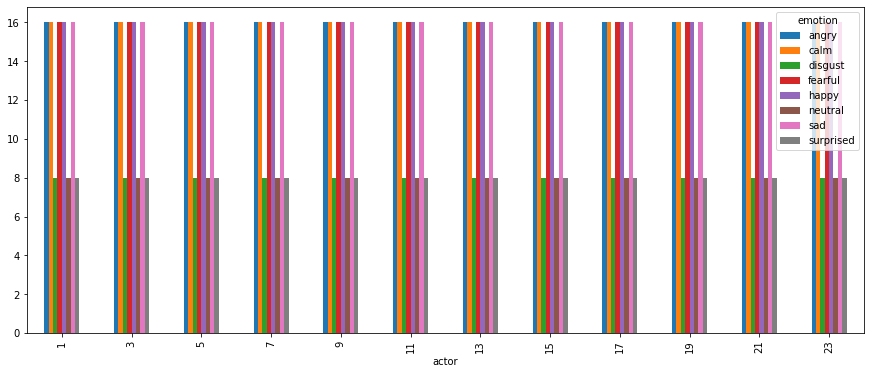

In [15]:
data_df_r_male.groupby(['actor', 'emotion'])['repetition'].count().unstack().plot.bar(figsize=(15,6))

Note that different emotion are reproduced in different counts for female and male actors. <br>
Note that emotions 'happy' and 'sad' are reproduced on same amounts for female and male. I will in fact train a CNN for emotion classification model to classify between 'happy' and 'sad'.